## Introduction

This notebook shows how PDBinf can be used to:
- accurately load PDB files
- guess residue names based on element graphs
- guess atom names based on SMARTS matching

In [1]:
import gemmi
import pdbinf
from pdbinf import guessing
from rdkit import Chem

### Problem statement

Natively RDKit will not handle non-standard amino acids.  E.g. this structure has a phosphothreonine residue (resname TPO);  the bonds are correctly guessed from geometric information, but the bond orders are left as single.

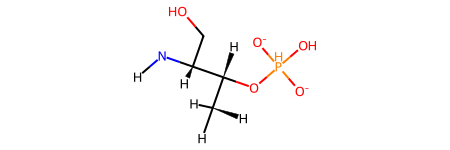

In [2]:
mol = Chem.MolFromPDBFile('./cdk2.pdb', removeHs=False)
tpo_section = []
for atom in mol.GetAtoms():
    if atom.GetMonomerInfo().GetResidueName() == 'TPO':
        tpo_section.append(atom.GetIdx())

tpo_residue = guessing.copy_mol_subset(mol, tpo_section)
tpo_residue

### PDBinf solution

By providing the `TPO.cif` (available from the PDB) we can apply the bond order information from that template to correctly assign bond orders to the TPO residue.
Under the hood this is using `Chem.MolFromPDBFile`, then iterating monomer by monomer to assign bond order information from the templates provided.

(TPO template from https://www.rcsb.org/ligand/TPO -> download Definition CIF format)

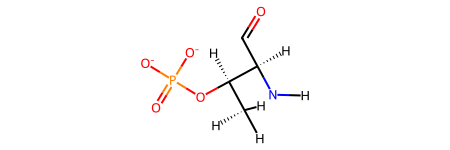

In [3]:
templates = gemmi.cif.read('./tpo.cif')

mol = pdbinf.load_pdb_file('./cdk2.pdb',
                           templates=[pdbinf.STANDARD_AA_DOC, templates])

tpo_section = []
for atom in mol.GetAtoms():
    if atom.GetMonomerInfo().GetResidueName() == 'TPO':
        tpo_section.append(atom.GetIdx())

tpo_residue = guessing.copy_mol_subset(mol, tpo_section)
tpo_residue

### Missing residue names

The template-based solution requires correctly knowing the name of each residue to match this to a template.
If the residues are mislabelled, there is a `guessing.guess_residue_name` function to match the element graph (therefore requiring bonds to have been guessed from geometry) to a template.  The `subset` kwarg allows a section of the entire molecule to be targetted for guessing.

E.g. here the TPO section of the molecule can be correctly guessed as being a TPO residue.

In [4]:
pdbinf.guessing.guess_residue_name(mol, templates,
                                  subset=tpo_section)

'TPO'

Under the hood, this is using rdkit `rdMolHash` to create a SMILES string of the element-graph.  This can then be quickly matched against the hash for each template.

In [5]:
pdbinf.guessing.normalised_hash(tpo_residue)

'CC(O[PH](O)(O)O)C(N)CO'

### Missing atom names

Similarly, sometimes atom names are incorrectly labelled, which can lead to difficulty downstream.
Once the correct template is identified, the `guessing.guess_atom_names` function can return the canonical atom names for a given residue.

In [6]:
pdbinf.guessing.guess_atom_names(mol, templates['TPO'], subset=tpo_section)

['N',
 'CA',
 'CB',
 'CG2',
 'OG1',
 'P',
 'O1P',
 'O2P',
 'O3P',
 'C',
 'O',
 'H',
 'HA',
 'HB',
 'HG21',
 'HG22',
 'HG23']